In [70]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
import os
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Check current directory and files
print("Current directory:", os.getcwd())
print("Files in directory:", os.listdir('.'))

print("Libraries imported successfully!")


Current directory: /Users/abhishekjindal/Downloads/RWSI _Analysis
Files in directory: ['.DS_Store', 'rwsi_comprehensive_eda.png', 'RWSI_Analysisf.ipynb', 'README.md', 'rwsi_data.csv', 'feature_importance.png', 'comprehensive_model_evaluation.png', '.git']
Libraries imported successfully!


## 1. Data Loading and Initial Exploration


In [71]:
# Load the data
import pandas as pd
import os

# Change to the correct directory where the CSV file is located
os.chdir('/Users/abhishekjindal/Downloads/RWSI _Analysis')
print(f"Current directory: {os.getcwd()}")
print(f"Files in directory: {os.listdir('.')}")

# Load the CSV file
df = pd.read_csv('rwsi_data.csv')


print("RETAIL WEB SESSION INTELLIGENCE (RWSI) DATA ANALYSIS")



print(f"Dataset shape: {df.shape}")
print(f"Total sessions: {len(df)}")
print(f"Features: {len(df.columns)}")


print(f"\nColumn names:")
print(list(df.columns))

print(f"\nData types:")
print(df.dtypes.value_counts().to_dict())

print(f"\nTarget variable distribution:")
print(df['MonetaryConversion'].value_counts())


Current directory: /Users/abhishekjindal/Downloads/RWSI _Analysis
Files in directory: ['.DS_Store', 'rwsi_comprehensive_eda.png', 'RWSI_Analysisf.ipynb', 'README.md', 'rwsi_data.csv', 'feature_importance.png', 'comprehensive_model_evaluation.png', '.git']
RETAIL WEB SESSION INTELLIGENCE (RWSI) DATA ANALYSIS
Dataset shape: (12330, 20)
Total sessions: 12330
Features: 20

Column names:
['SessionID', 'AdClicks', 'InfoSectionCount', 'InfoSectionTime', 'HelpPageVisits', 'HelpPageTime', 'ItemBrowseCount', 'ItemBrowseTime', 'ExitRateFirstPage', 'SessionExitRatio', 'PageEngagementScore', 'HolidayProximityIndex', 'VisitMonth', 'UserPlatformID', 'WebClientCode', 'MarketZone', 'TrafficSourceCode', 'UserCategory', 'IsWeekendVisit', 'MonetaryConversion']

Data types:
{dtype('float64'): 12, dtype('O'): 7, dtype('bool'): 1}

Target variable distribution:
MonetaryConversion
No     10422
Yes     1908
Name: count, dtype: int64


In [72]:
# Test data loading
print("Testing data loading...")
print(f"DataFrame type: {type(df)}")
print(f"DataFrame shape: {df.shape}")
print("First 5 rows of the dataset:")
df.head()


Testing data loading...
DataFrame type: <class 'pandas.core.frame.DataFrame'>
DataFrame shape: (12330, 20)
First 5 rows of the dataset:


,SessionID,AdClicks,InfoSectionCount,InfoSectionTime,HelpPageVisits,HelpPageTime,ItemBrowseCount,ItemBrowseTime,ExitRateFirstPage,SessionExitRatio,PageEngagementScore,HolidayProximityIndex,VisitMonth,UserPlatformID,WebClientCode,MarketZone,TrafficSourceCode,UserCategory,IsWeekendVisit,MonetaryConversion
0,jv3uDyqYltpoXreO,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,February,Windows,Safari,North America,1.0,Returning,False,No
1,eBHG5YGyco8TRlac,4.0,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,February,Android,Chrome,NaN,2.0,Returning,False,No
2,Lz5fuqr91SKGHb5N,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,February,MacOS,Safari,Other,3.0,Returning,False,No
3,cyOsumxkpNEvKIdc,4.0,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,February,iOS,NaN,Europe,4.0,Returning,False,No
4,F4rTMKOqtoPKzxw9,2.0,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,NaN,February,iOS,Internet Explorer,NaN,4.0,Returning,True,No


In [73]:
# Verify data loading worked

print(f" DataFrame created: {type(df)}")
print(f" Shape: {df.shape}")
print(f" Columns: {len(df.columns)}")
print(f" Target variable unique values: {df['MonetaryConversion'].unique()}")



 DataFrame created: <class 'pandas.core.frame.DataFrame'>
 Shape: (12330, 20)
 Columns: 20
 Target variable unique values: ['No' 'Yes']


In [74]:
# Missing values analysis

missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])


                       Missing Count  Missing Percentage
AdClicks                         863            6.999189
TrafficSourceCode                616            4.995945
MarketZone                       616            4.995945
WebClientCode                    616            4.995945
UserPlatformID                   493            3.998378
HolidayProximityIndex            493            3.998378
ItemBrowseCount                  493            3.998378
ItemBrowseTime                   493            3.998378
UserCategory                     493            3.998378
PageEngagementScore              369            2.992701
InfoSectionTime                  369            2.992701
InfoSectionCount                 369            2.992701
SessionExitRatio                 246            1.995134
HelpPageTime                     246            1.995134
HelpPageVisits                   246            1.995134
ExitRateFirstPage                123            0.997567


## 2. Exploratory Data Analysis (EDA)


In [75]:
# Target variable analysis

conversion_counts = df['MonetaryConversion'].value_counts()
print(conversion_counts)
conversion_rate = (df['MonetaryConversion'] == 'Yes').mean()
print(f"Overall conversion rate: {conversion_rate:.2%}")

# Behavior differences between converting and non-converting sessions
print("\nBehavior differences between converting and non-converting sessions:")
converting_sessions = df[df['MonetaryConversion'] == 'Yes']
non_converting_sessions = df[df['MonetaryConversion'] == 'No']

print("\nAverage metrics comparison:")
comparison_metrics = ['AdClicks', 'ItemBrowseCount', 'ItemBrowseTime', 'PageEngagementScore']
for metric in comparison_metrics:
    if metric in df.columns:
        conv_avg = converting_sessions[metric].mean()
        non_conv_avg = non_converting_sessions[metric].mean()
        print(f"{metric}: Converting={conv_avg:.2f}, Non-converting={non_conv_avg:.2f}")


MonetaryConversion
No     10422
Yes     1908
Name: count, dtype: int64
Overall conversion rate: 15.47%

Behavior differences between converting and non-converting sessions:

Average metrics comparison:
AdClicks: Converting=1.97, Non-converting=2.00
ItemBrowseCount: Converting=48.21, Non-converting=28.69
ItemBrowseTime: Converting=1873.67, Non-converting=1072.24
PageEngagementScore: Converting=27.36, Non-converting=1.98


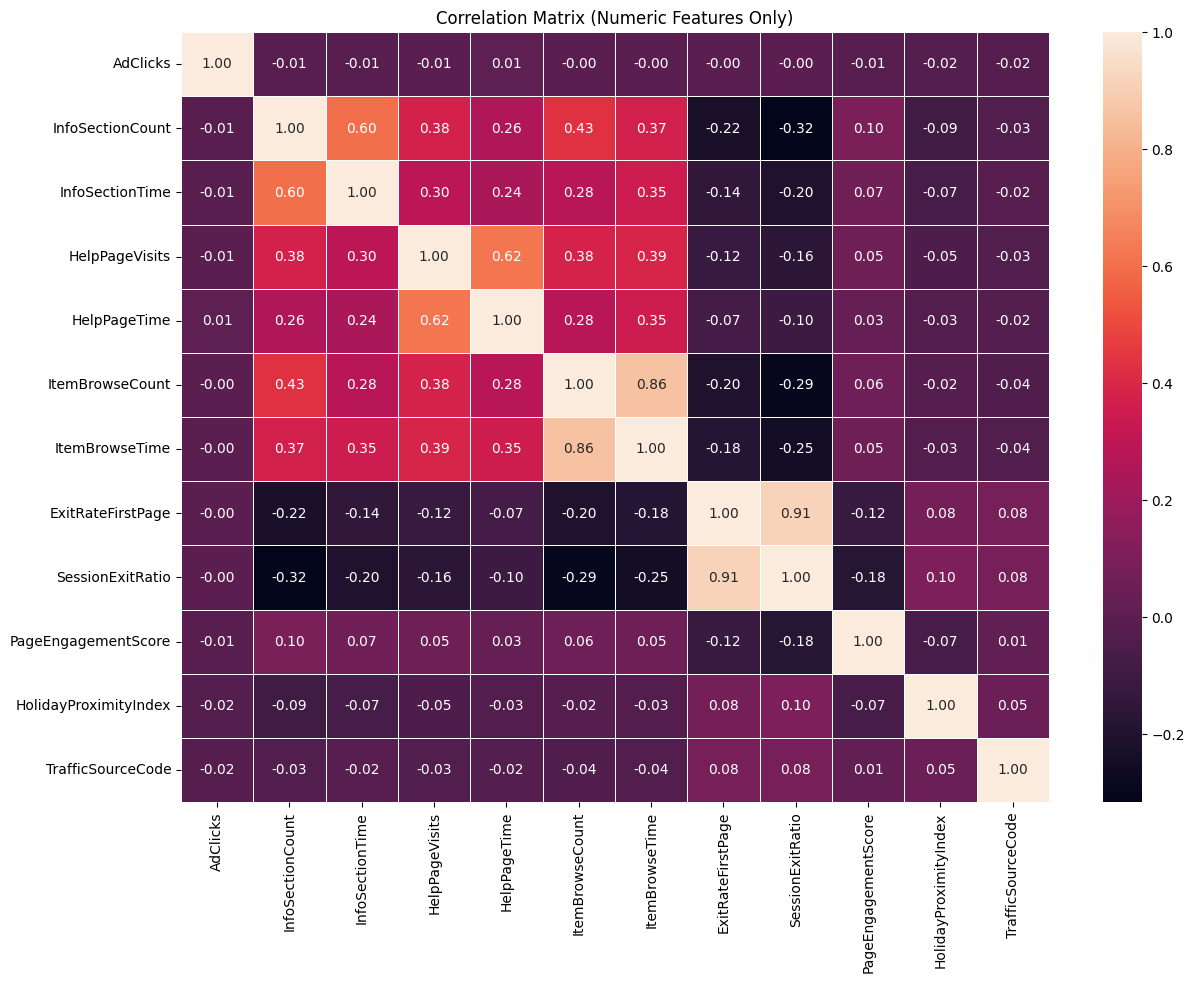

In [76]:
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Numeric Features Only)")
plt.show()


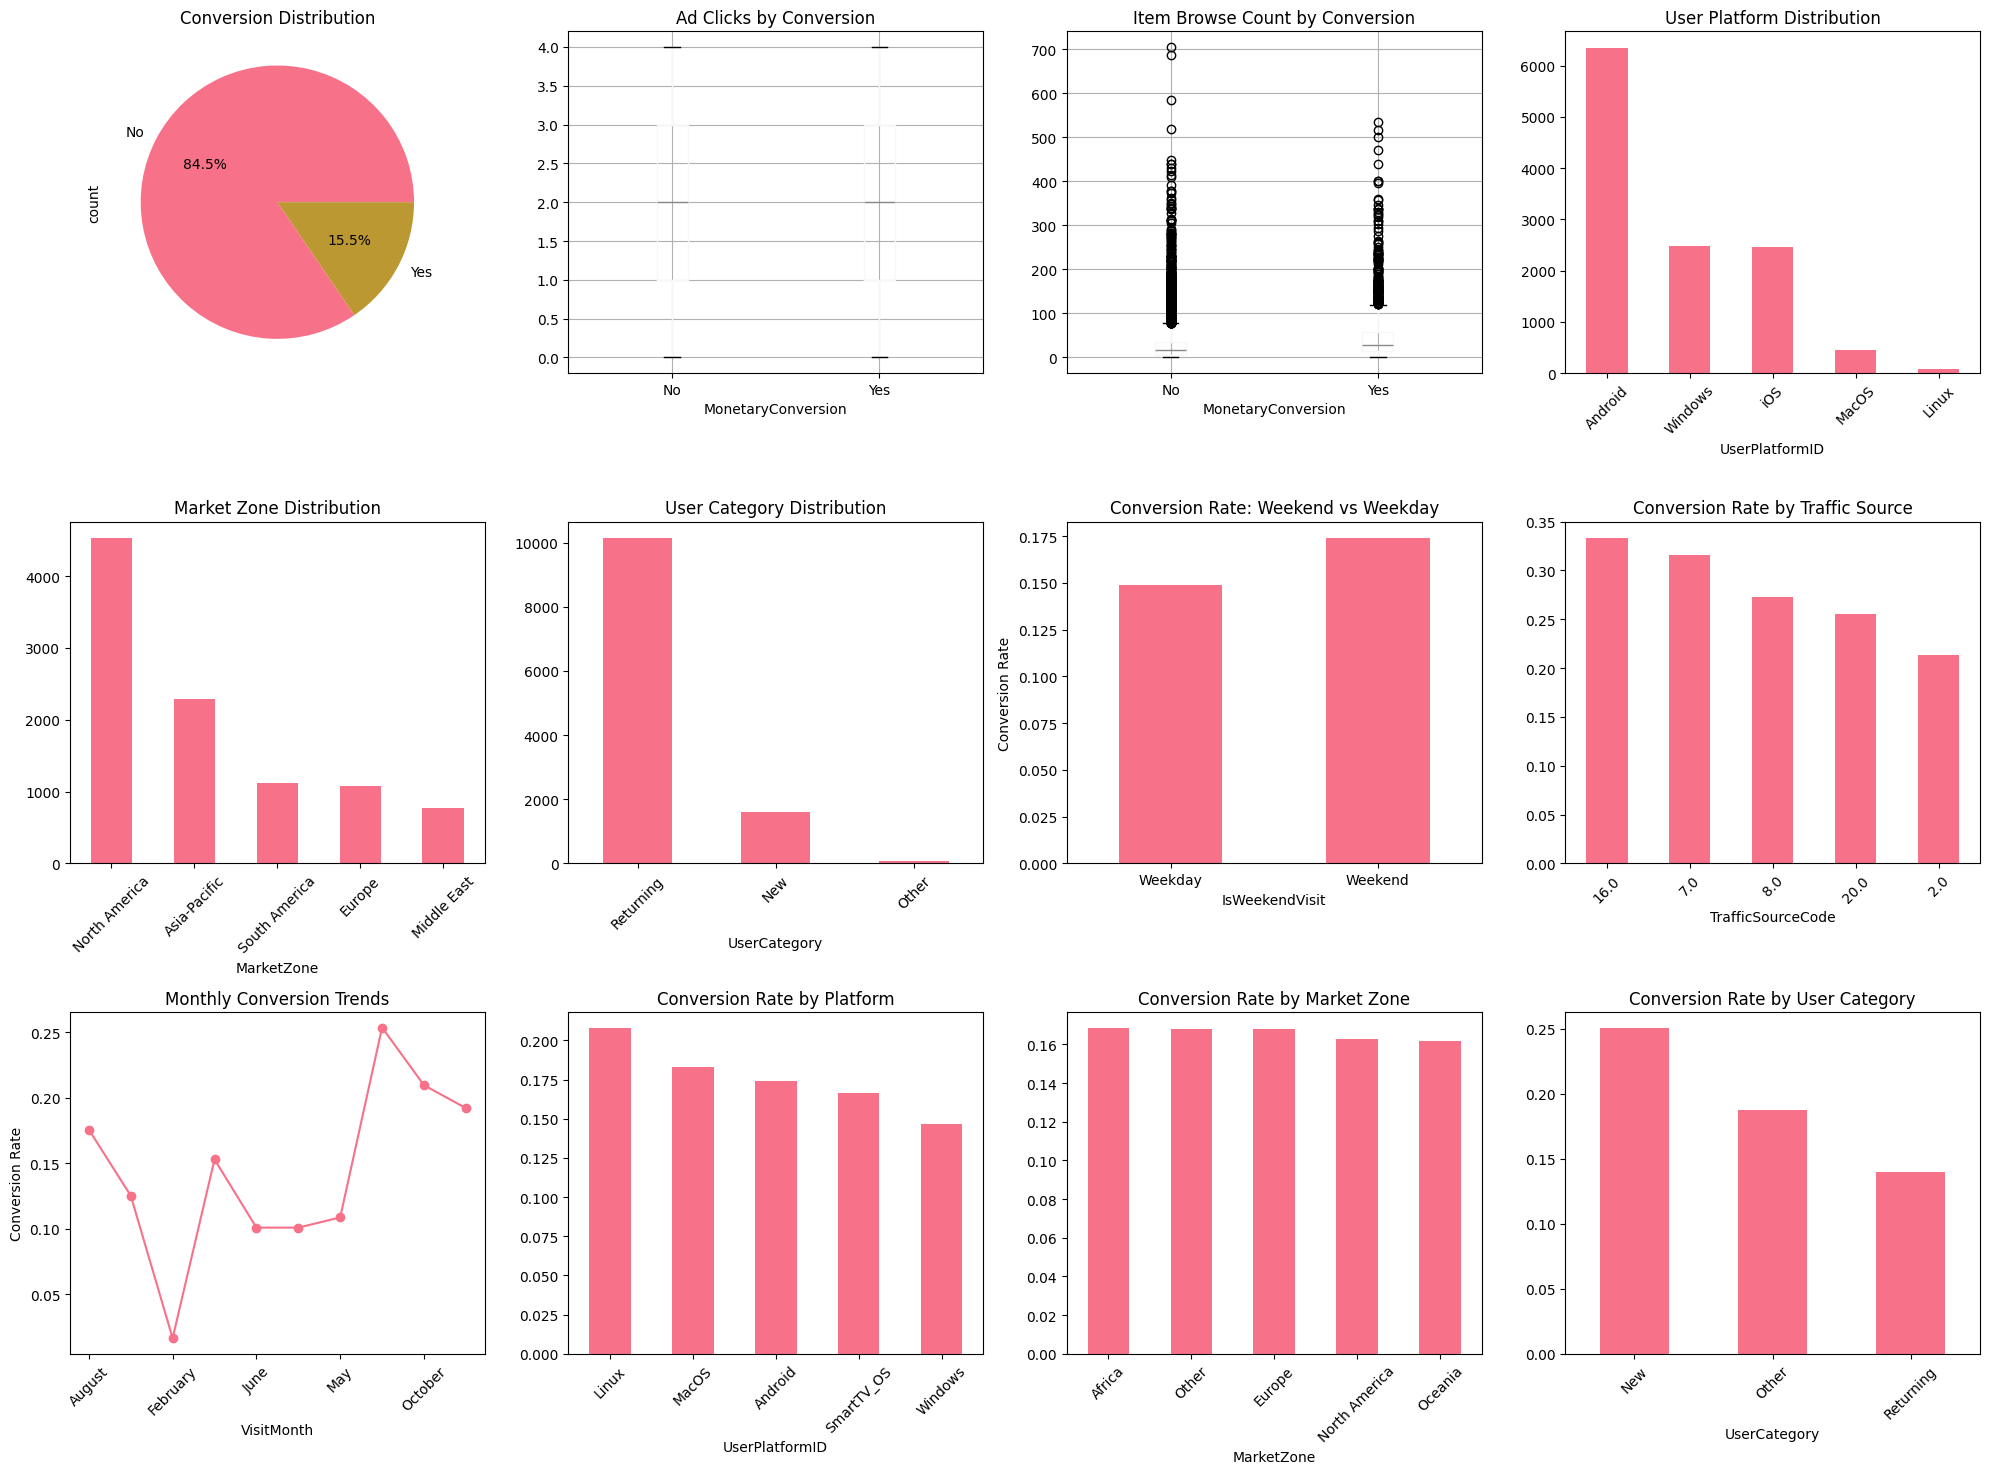

In [77]:
# Create comprehensive EDA visualizations
plt.figure(figsize=(20, 15))

# Plot 1: Target distribution
plt.subplot(3, 4, 1)
df['MonetaryConversion'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Conversion Distribution')

# Plot 2: AdClicks by conversion
plt.subplot(3, 4, 2)
df.boxplot(column='AdClicks', by='MonetaryConversion', ax=plt.gca())
plt.title('Ad Clicks by Conversion')
plt.suptitle('')  # Remove default title

# Plot 3: Item Browse Count by conversion
plt.subplot(3, 4, 3)
df.boxplot(column='ItemBrowseCount', by='MonetaryConversion', ax=plt.gca())
plt.title('Item Browse Count by Conversion')
plt.suptitle('')

# Plot 4: Platform distribution
plt.subplot(3, 4, 4)
df['UserPlatformID'].value_counts().head().plot(kind='bar')
plt.title('User Platform Distribution')
plt.xticks(rotation=45)

# Plot 5: Market Zone distribution
plt.subplot(3, 4, 5)
df['MarketZone'].value_counts().head().plot(kind='bar')
plt.title('Market Zone Distribution')
plt.xticks(rotation=45)

# Plot 6: User Category distribution
plt.subplot(3, 4, 6)
df['UserCategory'].value_counts().plot(kind='bar')
plt.title('User Category Distribution')
plt.xticks(rotation=45)

# Plot 7: Weekend vs Weekday conversion
plt.subplot(3, 4, 7)
weekend_conv = df.groupby('IsWeekendVisit')['MonetaryConversion'].apply(lambda x: (x == 'Yes').mean())
weekend_conv.plot(kind='bar')
plt.title('Conversion Rate: Weekend vs Weekday')
plt.ylabel('Conversion Rate')
plt.xticks([0, 1], ['Weekday', 'Weekend'], rotation=0)

# Plot 8: Traffic Source analysis
plt.subplot(3, 4, 8)
traffic_conv = df.groupby('TrafficSourceCode')['MonetaryConversion'].apply(lambda x: (x == 'Yes').mean()).sort_values(ascending=False)
traffic_conv.head().plot(kind='bar')
plt.title('Conversion Rate by Traffic Source')
plt.xticks(rotation=45)

# Plot 9: Monthly trends
plt.subplot(3, 4, 9)
monthly_conv = df.groupby('VisitMonth')['MonetaryConversion'].apply(lambda x: (x == 'Yes').mean())
monthly_conv.plot(kind='line', marker='o')
plt.title('Monthly Conversion Trends')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)

# Plot 10: Platform conversion rates
plt.subplot(3, 4, 10)
platform_conv = df.groupby('UserPlatformID')['MonetaryConversion'].apply(lambda x: (x == 'Yes').mean()).sort_values(ascending=False)
platform_conv.head().plot(kind='bar')
plt.title('Conversion Rate by Platform')
plt.xticks(rotation=45)

# Plot 11: Market Zone conversion rates
plt.subplot(3, 4, 11)
market_conv = df.groupby('MarketZone')['MonetaryConversion'].apply(lambda x: (x == 'Yes').mean()).sort_values(ascending=False)
market_conv.head().plot(kind='bar')
plt.title('Conversion Rate by Market Zone')
plt.xticks(rotation=45)

# Plot 12: User Category conversion rates
plt.subplot(3, 4, 12)
user_conv = df.groupby('UserCategory')['MonetaryConversion'].apply(lambda x: (x == 'Yes').mean()).sort_values(ascending=False)
user_conv.plot(kind='bar')
plt.title('Conversion Rate by User Category')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('rwsi_comprehensive_eda.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. Missing Value Handling


In [78]:
# Handle missing values
# Create a copy for processing
df_processed = df.copy()

# Fill missing values with median for numerical columns
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if df_processed[col].isnull().sum() > 0:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
        print(f"  {col}: Filled with median {median_val:.2f}")

# Fill missing values with mode for categorical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'SessionID' and df_processed[col].isnull().sum() > 0:
        mode_val = df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'Unknown'
        df_processed[col].fillna(mode_val, inplace=True)
        print(f"  {col}: Filled with mode '{mode_val}'")

print(f"\nRemaining missing values: {df_processed.isnull().sum().sum()}")


  AdClicks: Filled with median 2.00
  InfoSectionCount: Filled with median 1.00
  InfoSectionTime: Filled with median 8.00
  HelpPageVisits: Filled with median 0.00
  HelpPageTime: Filled with median 0.00
  ItemBrowseCount: Filled with median 18.00
  ItemBrowseTime: Filled with median 598.25
  ExitRateFirstPage: Filled with median 0.00
  SessionExitRatio: Filled with median 0.03
  PageEngagementScore: Filled with median 0.00
  HolidayProximityIndex: Filled with median 0.00
  TrafficSourceCode: Filled with median 2.00
  UserPlatformID: Filled with mode 'Android'
  WebClientCode: Filled with mode 'Chrome'
  MarketZone: Filled with mode 'North America'
  UserCategory: Filled with mode 'Returning'

Remaining missing values: 0


## 4. Feature Engineering


In [79]:
# Create new features
print("Creating new features...")

# Session engagement score
df_processed['SessionEngagementScore'] = (
    df_processed['AdClicks'] * 0.3 +
    df_processed['InfoSectionCount'] * 0.2 +
    df_processed['ItemBrowseCount'] * 0.5
)

# Time efficiency score
df_processed['TimeEfficiencyScore'] = (
    df_processed['ItemBrowseCount'] / (df_processed['ItemBrowseTime'] + 1)
)

# Help seeking behavior
df_processed['HelpSeekingBehavior'] = (
    df_processed['HelpPageVisits'] + df_processed['InfoSectionCount']
)

# High-value session indicator
df_processed['HighValueSession'] = (
    (df_processed['AdClicks'] > df_processed['AdClicks'].quantile(0.75)) &
    (df_processed['ItemBrowseCount'] > df_processed['ItemBrowseCount'].quantile(0.75))
).astype(int)

# Session duration category
df_processed['SessionDurationCategory'] = pd.cut(
    df_processed['ItemBrowseTime'],
    bins=[0, 100, 500, 1000, float('inf')],
    labels=['Very Short', 'Short', 'Medium', 'Long']
)

# Platform-Browser interaction
df_processed['PlatformBrowser'] = (
    df_processed['UserPlatformID'].astype(str) + '_' +
    df_processed['WebClientCode'].astype(str)
)

print("New features created:")
new_features = ['SessionEngagementScore', 'TimeEfficiencyScore', 'HelpSeekingBehavior',
               'HighValueSession', 'SessionDurationCategory', 'PlatformBrowser']
for feature in new_features:
    print(f"   {feature}")


Creating new features...
New features created:
   SessionEngagementScore
   TimeEfficiencyScore
   HelpSeekingBehavior
   HighValueSession
   SessionDurationCategory
   PlatformBrowser


## 5. Model Training - 5 Different Algorithms


In [80]:
# Prepare data for modeling
print("Preparing data for modeling...")

# Encode categorical variables
le_visit_month = LabelEncoder()
le_platform = LabelEncoder()
le_web_client = LabelEncoder()
le_market_zone = LabelEncoder()
le_user_category = LabelEncoder()
le_platform_browser = LabelEncoder()
le_duration_cat = LabelEncoder()

df_processed['VisitMonth_encoded'] = le_visit_month.fit_transform(df_processed['VisitMonth'].astype(str))
df_processed['UserPlatformID_encoded'] = le_platform.fit_transform(df_processed['UserPlatformID'].astype(str))
df_processed['WebClientCode_encoded'] = le_web_client.fit_transform(df_processed['WebClientCode'].astype(str))
df_processed['MarketZone_encoded'] = le_market_zone.fit_transform(df_processed['MarketZone'].astype(str))
df_processed['UserCategory_encoded'] = le_user_category.fit_transform(df_processed['UserCategory'].astype(str))
df_processed['PlatformBrowser_encoded'] = le_platform_browser.fit_transform(df_processed['PlatformBrowser'].astype(str))
df_processed['SessionDurationCategory_encoded'] = le_duration_cat.fit_transform(df_processed['SessionDurationCategory'].astype(str))

# Select features for modeling
feature_columns = [
    'AdClicks', 'InfoSectionCount', 'InfoSectionTime', 'HelpPageVisits',
    'HelpPageTime', 'ItemBrowseCount', 'ItemBrowseTime', 'ExitRateFirstPage',
    'SessionExitRatio', 'PageEngagementScore', 'HolidayProximityIndex',
    'TrafficSourceCode', 'IsWeekendVisit', 'VisitMonth_encoded',
    'UserPlatformID_encoded', 'WebClientCode_encoded', 'MarketZone_encoded',
    'UserCategory_encoded', 'SessionEngagementScore', 'TimeEfficiencyScore',
    'HelpSeekingBehavior', 'HighValueSession', 'PlatformBrowser_encoded',
    'SessionDurationCategory_encoded'
]

X = df_processed[feature_columns]
y = (df_processed['MonetaryConversion'] == 'Yes').astype(int)

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Preparing data for modeling...
Feature matrix shape: (12330, 24)
Target distribution: {0: 10422, 1: 1908}
Training set: 9864 samples
Test set: 2466 samples


In [81]:
# Train all 5 models
# Scale features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred_proba)
print(f"  Accuracy: {lr_accuracy:.4f}, AUC: {lr_auc:.4f}")

# 2. Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred_proba)
print(f"  Accuracy: {rf_accuracy:.4f}, AUC: {rf_auc:.4f}")

# 3. Linear Regression
print("Training Linear Regression...")
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
linear_pred_proba = linear_model.predict(X_test_scaled)
linear_pred = (linear_pred_proba > 0.5).astype(int)
linear_accuracy = accuracy_score(y_test, linear_pred)
linear_auc = roc_auc_score(y_test, linear_pred_proba)
linear_mse = mean_squared_error(y_test, linear_pred_proba)
linear_r2 = r2_score(y_test, linear_pred_proba)
print(f"  Accuracy: {linear_accuracy:.4f}, AUC: {linear_auc:.4f}, MSE: {linear_mse:.4f}, R²: {linear_r2:.4f}")

# 4. Gradient Descent (SGD Classifier)
print("Training Gradient Descent (SGD Classifier)...")
sgd_model = SGDClassifier(random_state=42, max_iter=1000, loss='log_loss')
sgd_model.fit(X_train_scaled, y_train)
sgd_pred = sgd_model.predict(X_test_scaled)
sgd_pred_proba = sgd_model.predict_proba(X_test_scaled)[:, 1]
sgd_accuracy = accuracy_score(y_test, sgd_pred)
sgd_auc = roc_auc_score(y_test, sgd_pred_proba)
print(f"  Accuracy: {sgd_accuracy:.4f}, AUC: {sgd_auc:.4f}")

# 5. Decision Tree
print("Training Decision Tree...")
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=20)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_pred_proba = dt_model.predict_proba(X_test)[:, 1]
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_auc = roc_auc_score(y_test, dt_pred_proba)
print(f"  Accuracy: {dt_accuracy:.4f}, AUC: {dt_auc:.4f}")

print("\nAll models trained successfully!")


Training Logistic Regression...
  Accuracy: 0.8816, AUC: 0.8530
Training Random Forest...
  Accuracy: 0.8986, AUC: 0.9027
Training Linear Regression...
  Accuracy: 0.8702, AUC: 0.8632, MSE: 0.0993, R²: 0.2415
Training Gradient Descent (SGD Classifier)...
  Accuracy: 0.8828, AUC: 0.8277
Training Decision Tree...
  Accuracy: 0.8889, AUC: 0.8608

All models trained successfully!


## 6. Model Evaluation and Comparison


In [82]:
# Comprehensive model comparison
models = {
    'Logistic Regression': (lr_model, lr_pred, lr_accuracy, lr_auc, 'scaled'),
    'Random Forest': (rf_model, rf_pred, rf_accuracy, rf_auc, 'unscaled'),
    'Linear Regression': (linear_model, linear_pred, linear_accuracy, linear_auc, 'scaled'),
    'Gradient Descent': (sgd_model, sgd_pred, sgd_accuracy, sgd_auc, 'scaled'),
    'Decision Tree': (dt_model, dt_pred, dt_accuracy, dt_auc, 'unscaled')
}

# Create comprehensive comparison table
print(f"{'Model':<20} {'Accuracy':<10} {'AUC':<10} {'MSE':<10} {'R²':<10} {'Data Type':<12}")


for name, (model, pred, acc, auc, data_type) in models.items():
    if name == 'Linear Regression':
        mse = linear_mse
        r2 = linear_r2
    else:
        mse = mean_squared_error(y_test, pred)
        r2 = r2_score(y_test, pred)

    print(f"{name:<20} {acc:<10.4f} {auc:<10.4f} {mse:<10.4f} {r2:<10.4f} {data_type:<12}")

# Find best model by AUC
best_model_name = max(models.keys(), key=lambda x: models[x][3])  # Best by AUC
best_model, best_pred, best_accuracy, best_auc, best_data_type = models[best_model_name]

print(f"\n BEST MODEL: {best_model_name}")
print(f"  Accuracy: {best_accuracy:.4f}")
print(f"  AUC Score: {best_auc:.4f}")
print(f"  Data Type: {best_data_type}")


Model                Accuracy   AUC        MSE        R²         Data Type   
Logistic Regression  0.8816     0.8530     0.1184     0.0955     scaled      
Random Forest        0.8986     0.9027     0.1014     0.2256     unscaled    
Linear Regression    0.8702     0.8632     0.0993     0.2415     scaled      
Gradient Descent     0.8828     0.8277     0.1172     0.1048     scaled      
Decision Tree        0.8889     0.8608     0.1111     0.1512     unscaled    

 BEST MODEL: Random Forest
  Accuracy: 0.8986
  AUC Score: 0.9027
  Data Type: unscaled


## 7. Feature Importance Analysis


Top 15 Most Important Features for Random Forest:
                   feature  importance
9      PageEngagementScore    0.332701
8         SessionExitRatio    0.075944
6           ItemBrowseTime    0.059640
18  SessionEngagementScore    0.056038
19     TimeEfficiencyScore    0.053307
5          ItemBrowseCount    0.048926
2          InfoSectionTime    0.046449
7        ExitRateFirstPage    0.045408
13      VisitMonth_encoded    0.037050
20     HelpSeekingBehavior    0.031168
1         InfoSectionCount    0.028507
11       TrafficSourceCode    0.024518
16      MarketZone_encoded    0.024495
0                 AdClicks    0.022089
4             HelpPageTime    0.020705


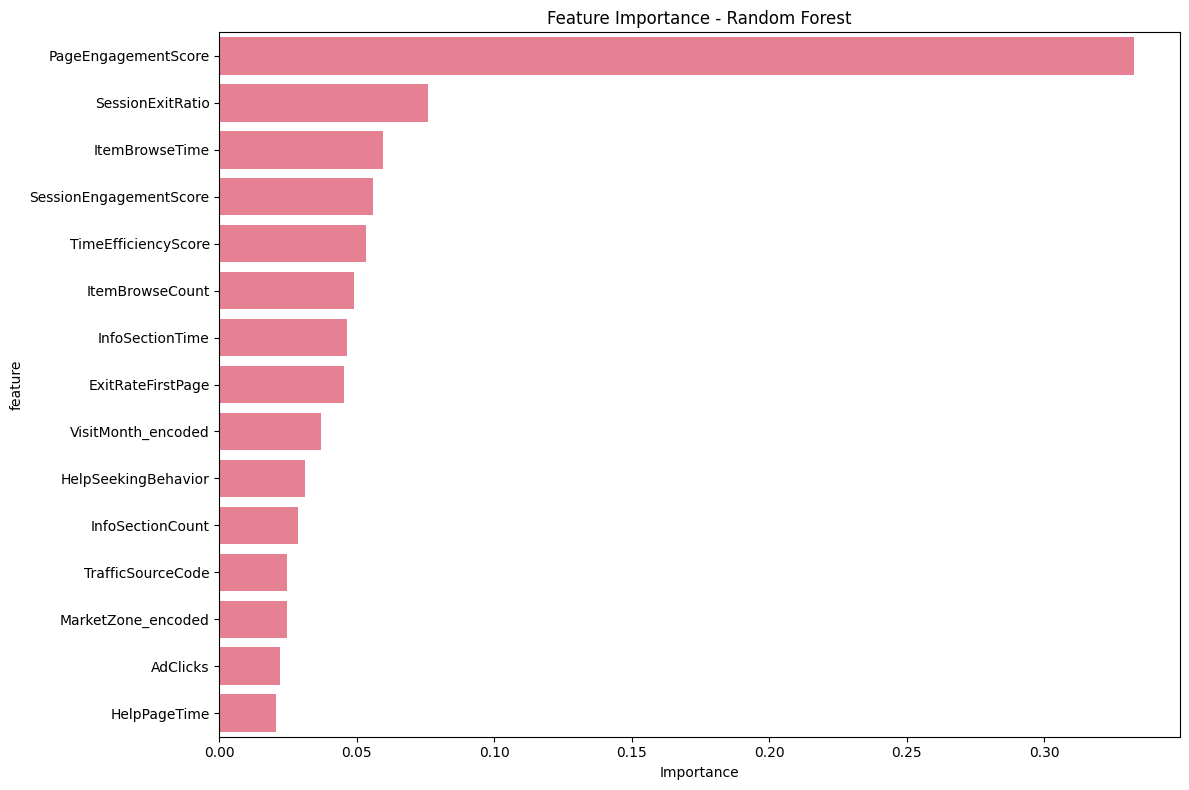


Detailed Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2084
           1       0.76      0.51      0.61       382

    accuracy                           0.90      2466
   macro avg       0.84      0.74      0.78      2466
weighted avg       0.89      0.90      0.89      2466



In [83]:
# Feature importance for best model
if best_model_name in ['Random Forest', 'Decision Tree']:
    feature_importance = best_model.feature_importances_
    feature_names = X.columns

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print(f"Top 15 Most Important Features for {best_model_name}:")
    print(importance_df.head(15))

    # Plot
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

# Classification report
print(f"\nDetailed Classification Report for {best_model_name}:")
print(classification_report(y_test, best_pred))


## 8. Business Insights and Recommendations


In [84]:
# Generate business insights
print("KEY FINDINGS AND INSIGHTS")




# Behavioral patterns
print("\n1. BEHAVIORAL PATTERNS:")
print(f"   - Converting sessions: {converting_sessions['ItemBrowseCount'].mean():.1f} avg item views")
print(f"   - Non-converting sessions: {non_converting_sessions['ItemBrowseCount'].mean():.1f} avg item views")
print(f"   - Converting sessions spend {converting_sessions['ItemBrowseTime'].mean():.1f} seconds browsing")
print(f"   - Non-converting sessions spend {non_converting_sessions['ItemBrowseTime'].mean():.1f} seconds browsing")

# Platform insights
print("\n2. PLATFORM INSIGHTS:")
best_platform = df_processed.groupby('UserPlatformID')['MonetaryConversion'].apply(lambda x: (x == 'Yes').mean()).sort_values(ascending=False)
print(f"   - Best platform: {best_platform.index[0]} ({best_platform.iloc[0]:.2%} conversion)")

# Geographic insights
print("\n3. GEOGRAPHIC INSIGHTS:")
best_market = df_processed.groupby('MarketZone')['MonetaryConversion'].apply(lambda x: (x == 'Yes').mean()).sort_values(ascending=False)
print(f"   - Best market: {best_market.index[0]} ({best_market.iloc[0]:.2%} conversion)")

# User segmentation
print("\n4. USER SEGMENTATION:")
best_user = df_processed.groupby('UserCategory')['MonetaryConversion'].apply(lambda x: (x == 'Yes').mean()).sort_values(ascending=False)
print(f"   - Best user category: {best_user.index[0]} ({best_user.iloc[0]:.2%} conversion)")




KEY FINDINGS AND INSIGHTS

1. BEHAVIORAL PATTERNS:
   - Converting sessions: 48.2 avg item views
   - Non-converting sessions: 28.7 avg item views
   - Converting sessions spend 1873.7 seconds browsing
   - Non-converting sessions spend 1072.2 seconds browsing

2. PLATFORM INSIGHTS:
   - Best platform: Linux (20.78% conversion)

3. GEOGRAPHIC INSIGHTS:
   - Best market: Africa (16.84% conversion)

4. USER SEGMENTATION:
   - Best user category: New (25.05% conversion)


## 9. Hyperparameter Tuning

Now we'll perform hyperparameter tuning for each model to optimize their performance using GridSearchCV.


In [85]:
# Import GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


### 9.1 Random Forest Hyperparameter Tuning


In [86]:
# Random Forest Hyperparameter Tuning
print("Tuning Random Forest hyperparameters...")

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Create GridSearchCV object
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
rf_grid_search.fit(X_train, y_train)

# Get best parameters and score
rf_best_params = rf_grid_search.best_params_
rf_best_score = rf_grid_search.best_score_

print(f"Best parameters: {rf_best_params}")
print(f"Best CV score: {rf_best_score:.4f}")

# Train model with best parameters
rf_tuned = RandomForestClassifier(**rf_best_params, random_state=42)
rf_tuned.fit(X_train, y_train)
rf_tuned_pred = rf_tuned.predict(X_test)
rf_tuned_pred_proba = rf_tuned.predict_proba(X_test)[:, 1]
rf_tuned_accuracy = accuracy_score(y_test, rf_tuned_pred)
rf_tuned_auc = roc_auc_score(y_test, rf_tuned_pred_proba)

print(f"Tuned Random Forest - Accuracy: {rf_tuned_accuracy:.4f}, AUC: {rf_tuned_auc:.4f}")
print(f"Improvement: Accuracy {rf_tuned_accuracy - rf_accuracy:+.4f}, AUC {rf_tuned_auc - rf_auc:+.4f}")


Tuning Random Forest hyperparameters...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.9207
Tuned Random Forest - Accuracy: 0.9027, AUC: 0.9157
Improvement: Accuracy +0.0041, AUC +0.0130
